In [ ]:
# Step1: Import libraries and mount Google Drive
import pandas as pd
import numpy as np
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# step2  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# step3 Set paths

data_csv_path = '/content/drive/MyDrive/archive/Training_set.csv'
images_folder_path = '/content/drive/MyDrive/archive/train'
Additional_monarch_path =  '/content/drive/MyDrive/archive/new_monarch_butterfly_data_265pxl/data/train/monarch'

In [ ]:
#Step 4
import os
import shutil
import pandas as pd
import cv2
from tqdm import tqdm  # for progress bars

# Step 1: Define paths
data_csv_path = '/content/drive/MyDrive/archive/Training_set.csv'
images_folder_path = '/content/drive/MyDrive/archive/train'
additional_monarch_path = '/content/drive/MyDrive/archive/new_monarch_butterfly_data_265pxl/data/train/monarch'
TARGET_SIZE = (224, 224)

# Step 2: Create new destination folders
project_root = '/content/drive/MyDrive/Ajay_Butterfly_Project'
monarch_dir = os.path.join(project_root, 'images', 'monarch')
non_monarch_dir = os.path.join(project_root, 'images', 'non-monarch')
os.makedirs(monarch_dir, exist_ok=True)
os.makedirs(non_monarch_dir, exist_ok=True)

print("📁 Creating project folders and loading CSV...")
df = pd.read_csv(data_csv_path)
df['label'] = df['label'].str.upper()

print(f"📄 Total records in CSV: {len(df)}\n")

# Step 3: Copy and resize CSV-labeled images
new_records = []
missing_files = []

print("🔄 Processing labeled CSV images...\n")
for idx, row in enumerate(tqdm(df.itertuples(), total=len(df))):
    filename = row.filename
    label = row.label
    src_path = os.path.join(images_folder_path, label, filename)

    # Choose destination based on label
    if label == 'MONARCH':
        dst_path = os.path.join(monarch_dir, filename)
        label_out = 'monarch'
    else:
        dst_path = os.path.join(non_monarch_dir, filename)
        label_out = 'non-monarch'

    try:
        img = cv2.imread(src_path)
        if img is not None:
            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(dst_path, img_resized)
            new_records.append({'filename': filename, 'label': label_out})
        else:
            print(f"⚠️ Skipped unreadable image: {src_path}")
    except Exception as e:
        print(f"❌ Error copying {src_path}: {e}")
        missing_files.append(src_path)

print(f"\n✅ Done copying {len(new_records)} images from CSV.")
if missing_files:
    print(f"⚠️ {len(missing_files)} missing/unreadable files were skipped.")

# Step 4: Copy and resize additional monarch images
print("\n📥 Copying extra monarch images...")

extra_files = [f for f in os.listdir(additional_monarch_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
extra_count = 0

for file in tqdm(extra_files):
    src_path = os.path.join(additional_monarch_path, file)
    dst_path = os.path.join(monarch_dir, file)
    try:
        img = cv2.imread(src_path)
        if img is not None:
            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(dst_path, img_resized)
            new_records.append({'filename': file, 'label': 'monarch'})
            extra_count += 1
        else:
            print(f"⚠️ Skipped unreadable image: {file}")
    except Exception as e:
        print(f"⚠️ Could not copy {file}: {e}")

print(f"\n🦋 {extra_count} additional monarch images copied and resized.")

# Step 5: Save final CSV
final_csv_path = os.path.join(project_root, 'Ajay_Training_set.csv')
df_final = pd.DataFrame(new_records).sort_values('filename').reset_index(drop=True)
df_final.to_csv(final_csv_path, index=False)

# Step 6: Summary
print("\n✅ Final Summary:")
print(f"📁 Output directory: {project_root}")
print(f"📝 CSV saved to: {final_csv_path}")
print(f"🖼️ Total monarch images: {sum([r['label'] == 'monarch' for r in new_records])}")
print(f"🦋 Total non-monarch images: {sum([r['label'] == 'non-monarch' for r in new_records])}")
print(f"📦 Total combined images: {len(new_records)}")



📁 Creating project folders and loading CSV...
📄 Total records in CSV: 6499

🔄 Processing labeled CSV images...



100%|██████████| 6499/6499 [27:47<00:00,  3.90it/s]



✅ Done copying 6499 images from CSV.

📥 Copying extra monarch images...


100%|██████████| 802/802 [00:16<00:00, 48.01it/s]


🦋 802 additional monarch images copied and resized.

✅ Final Summary:
📁 Output directory: /content/drive/MyDrive/Ajay_Butterfly_Project
📝 CSV saved to: /content/drive/MyDrive/Ajay_Butterfly_Project/Ajay_Training_set.csv
🖼️ Total monarch images: 892
🦋 Total non-monarch images: 6409
📦 Total combined images: 7301


In [ ]:
import os
import shutil
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Step 1: Define source and target paths
csv_path = '/content/drive/MyDrive/Ajay_Butterfly_Project/Ajay_Training_set.csv'
image_root = '/content/drive/MyDrive/Ajay_Butterfly_Project/images'
output_root = '/content/drive/MyDrive/Ajay_Butterfly_Project_Balanced'
target_size = (224, 224)

# Step 2: Load and balance the data
df = pd.read_csv(csv_path)
df_monarch = df[df['label'] == 'monarch']
df_nonmonarch = df[df['label'] == 'non-monarch']
min_count = min(len(df_monarch), len(df_nonmonarch))

df_monarch_bal = df_monarch.sample(n=min_count, random_state=42)
df_nonmonarch_bal = df_nonmonarch.sample(n=min_count, random_state=42)

df_balanced = pd.concat([df_monarch_bal, df_nonmonarch_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split into train/val/test
train_df, temp_df = train_test_split(df_balanced, test_size=0.30, stratify=df_balanced['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42)

# Step 4: Create folder structure
for split in ['train', 'val', 'test']:
    for label in ['monarch', 'non-monarch']:
        os.makedirs(os.path.join(output_root, split, label), exist_ok=True)

# Step 5: Copy, resize, normalize, and save images
def process_and_save_images(df, split):
    m_count, n_count = 0, 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
        label = row['label']
        filename = row['filename']
        src_path = os.path.join(image_root, label, filename)
        dst_path = os.path.join(output_root, split, label, filename)

        try:
            img = cv2.imread(src_path)
            if img is not None:
                img_resized = cv2.resize(img, target_size)
                img_normalized = (img_resized / 255.0 * 255).astype('uint8')  # Normalize then re-encode
                cv2.imwrite(dst_path, img_normalized)
                if label == 'monarch':
                    m_count += 1
                else:
                    n_count += 1
            else:
                print(f"⚠️ Skipped unreadable image: {src_path}")
        except Exception as e:
            print(f"❌ Error processing {src_path}: {e}")
    return m_count, n_count

# Step 6: Run processing for all splits
train_m, train_n = process_and_save_images(train_df, 'train')
val_m, val_n = process_and_save_images(val_df, 'val')
test_m, test_n = process_and_save_images(test_df, 'test')

# Step 7: Final report
print("\n📊 Final Balanced Dataset Summary (normalized and saved):")
print(f"Train: {train_m} monarch, {train_n} non-monarch")
print(f"Val:   {val_m} monarch, {val_n} non-monarch")
print(f"Test:  {test_m} monarch, {test_n} non-monarch")
print(f"\n📁 All data saved to: {output_root}")



Processing test: 100%|██████████| 268/268 [00:07<00:00, 38.20it/s]


📊 Final Balanced Dataset Summary (normalized and saved):
Train: 624 monarch, 624 non-monarch
Val:   134 monarch, 134 non-monarch
Test:  134 monarch, 134 non-monarch

📁 All data saved to: /content/drive/MyDrive/Ajay_Butterfly_Project_Balanced


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_path = '/content/drive/MyDrive/Ajay_Butterfly_Project_Balanced'

# Create ImageDataGenerators with normalization
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_loader = train_gen.flow_from_directory(
    directory=os.path.join(data_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_loader = val_gen.flow_from_directory(
    directory=os.path.join(data_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_loader = test_gen.flow_from_directory(
    directory=os.path.join(data_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1248 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Found 268 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.5534 - loss: 1.0666 - val_accuracy: 0.7351 - val_loss: 0.5455
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.7499 - loss: 0.5171 - val_accuracy: 0.7836 - val_loss: 0.4508
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8196 - loss: 0.4162 - val_accuracy: 0.7873 - val_loss: 0.3796
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.8615 - loss: 0.3262 - val_accuracy: 0.8433 - val_loss: 0.3274
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.9069 - loss: 0.2382 - val_accuracy: 0.8918 - val_loss: 0.2868
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9094 - loss: 0.2182 - val_accuracy: 0.8955 - val_loss: 0.2946
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9543 - loss: 0.1215 - val_accuracy: 0.8582 - val_loss: 0.3633
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.9598 - loss: 0.1102 - val_accuracy: 0.8993 - v

In [ ]:
# Test accuracy
loss, acc = model.evaluate(test_loader)
print(f"\n🧪 Test Accuracy: {acc:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 947ms/step - accuracy: 0.9294 - loss: 0.2426

🧪 Test Accuracy: 0.9179


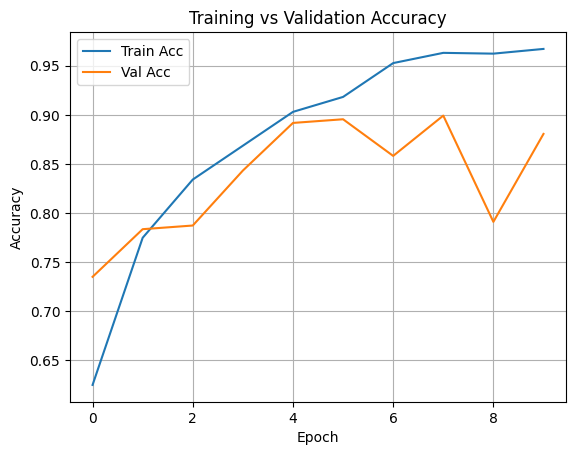

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


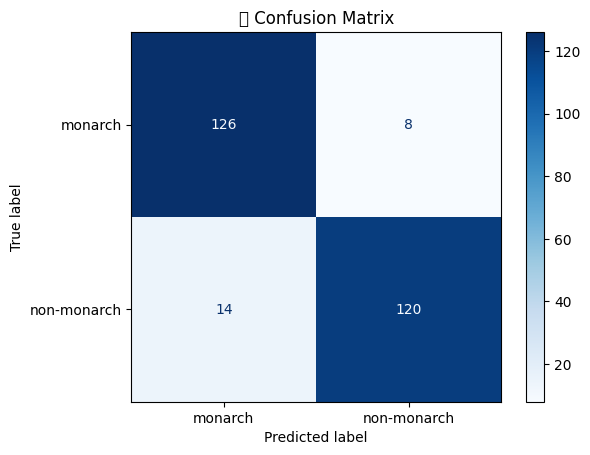

📊 Classification Report:

              precision    recall  f1-score   support

     monarch       0.90      0.94      0.92       134
 non-monarch       0.94      0.90      0.92       134

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict on test set
y_pred_prob = model.predict(test_loader)
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

# Step 2: True labels
y_true = test_loader.classes
class_names = list(test_loader.class_indices.keys())  # ['monarch', 'non-monarch'] (alphabetical)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("🦋 Confusion Matrix")
plt.grid(False)
plt.show()

# Step 4: Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("📊 Classification Report:\n")
print(report)


In [ ]:
# Save the full model (architecture + weights + optimizer)
model.save('/content/drive/MyDrive/Ajay_Butterfly_Project_Balanced/monarch_classifier_model.h5')
print("✅ Model saved to Google Drive!")


✅ Model saved to Google Drive!
